In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical


/Users/dheerajakshay/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
# Extracts raw pixel array from images
def get_image_vector(image,size=(64,64)):
    return cv2.resize(image,size).flatten()

In [8]:
# Extracts the color histogram from images
def extract_color_histogram(image,bins = (8,8,8)):
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()


In [9]:
train_dir = "train/train/"
test_dir = "test_stg1/test_stg1"


In [10]:
classes = os.listdir(train_dir)

In [11]:
# Get the training data paths

image_path_list = []
for c in classes:
    fish_images = [train_dir+c+'/'+item for item in os.listdir(train_dir+c+'/')]
    image_path_list.extend(fish_images)

In [12]:
# Get the labels

labels = []
for c in classes:
    l = [c]*len(os.listdir(train_dir+c+'/'))
    labels.extend(l)
    

In [9]:
# Encode the labels

labels = LabelEncoder().fit_transform(labels)


0  completed
1000  completed
2000  completed
3000  completed


<IPython.core.display.Javascript object>


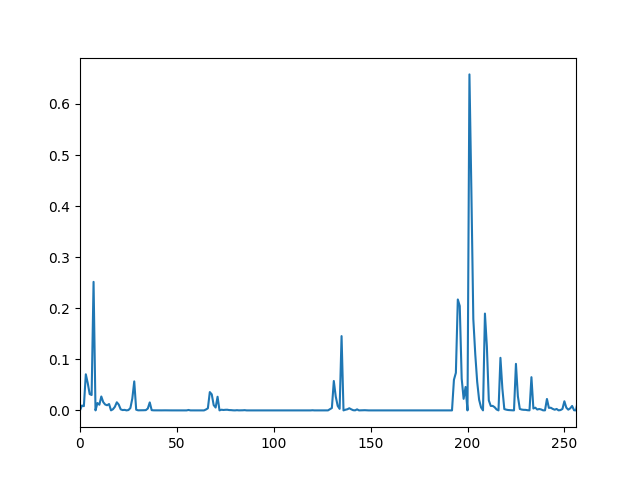

In [13]:
# Get the color histograms from the images

features = []
for i,image_path in enumerate(image_path_list):
    image = cv2.imread(image_path)
    hist = extract_color_histogram(image)
    features.append(hist)
    if(i%1000==0):
        print(str(i)+ "  completed")
plt.plot(hist)
plt.xlim([0,256])
plt.show()

In [11]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.25, random_state = 42)

In [12]:
model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)


In [13]:
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [14]:
accuracy = model.score(X_test,y_test)

In [15]:
print(accuracy)

0.925925925926


In [16]:
preds_validation = model.predict_proba(X_test)

In [17]:
from sklearn.metrics import log_loss

In [18]:
log_loss(y_test,preds_validation)

1.5111025575597354

In [19]:
test_files = [im for im in os.listdir(test_dir)]


In [20]:
test_dir +'/'+ test_files[0]

'test_stg1/test_stg1/img_00005.jpg'

In [22]:
test_features = []
for i,image_path in enumerate(test_files):
    image = cv2.imread(test_dir + '/'+ image_path)
    hist = extract_color_histogram(image)
    test_features.append(hist)
    if(i%1000==0):
        print(str(i)+ "  completed")

0  completed


In [23]:
preds = model.predict_proba(test_features)

In [24]:
submission1 = pd.DataFrame(preds, columns= os.listdir("train/train/"))
submission1.insert(0, 'image', test_files)
submission1.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,img_00007.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,img_00009.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,img_00018.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,img_00027.jpg,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [25]:
clipped_preds = np.clip(preds,(1-0.82)/7,0.82)

submission2 = pd.DataFrame(clipped_preds, columns= os.listdir("train/train/"))
submission2.insert(0, 'image', test_files)
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.820000
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
4,img_00027.jpg,0.500000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.500000


In [26]:
submission2.to_csv("K_neighbors_submission.csv",index = False)

score = 1.57576